# ROUNDTRIP MODELs

In [40]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import random
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import models.rf as models_rf
import models.fcnn as models_fcnn
import models.vae as models_vae

### Loading the dataset

In [3]:
filename='datasets/pulse_and_dazzler_240918.h5'

#read the Dazller input data
df_input=pd.read_hdf(filename,'df_input')

#read the reconstructed pulse data
df_time_200=pd.read_hdf(filename,'df_time_200')
df_pulse_200=pd.read_hdf(filename,'df_pulse_200')
t_200=df_time_200.to_numpy()

### Drop the show with bad goodness

In [4]:
goodness_val=1.3
df_input_reduced=df_input[df_input['goodness']>goodness_val]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

### Define model variables

In [7]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train, X_test, y_train, y_test = train_test_split(df_input_reduced[['order2', 'order3', 'order4']], df_pulse_200_reduced, test_size=0.3, random_state=101)

In [10]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cuda


## Forward model: RF

In [14]:
def train_rf_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=RandomForestRegressor(n_estimators=n_estimators,
                                            max_features=max_features,
                                            max_depth=max_depth,
                                              random_state=random_state)
    forward_model_rf.fit(X_train, y_train)
    #y_predict_forward=forward_model_rf.predict(X_test)

    #study the erro distribution
    #df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    #df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf #,df_error_forward_rf

In [15]:
forward_model_rf=train_rf_forward(X_train, X_test, y_train, y_test)

## Roundtrip models

### Random Forest

In [17]:
roundmodel_rf=models_rf.ROUNDmodelRF(X_train,X_test,y_train,y_test)
roundmodel_rf.train()
y_predict_round=roundmodel_rf.predict(y_test)
mae_error_round=roundmodel_rf.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### MLP

In [19]:
#round model NN
roundmodel_mlp=models_fcnn.ROUNDmodelNN(X_train,y_train,X_test,y_test,device)
roundmodel_mlp.train(100,#epochs FWD
                 128,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   400,#epochs  BWD
                 128,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round=roundmodel_mlp.predict(y_test)
error_round_model_mlp=roundmodel_mlp.error_calc_mae()

Training the forward model
Finished epoch 0,latest loss 0.052419938147068024
Finished epoch 20,latest loss 0.0012195497984066606
Finished epoch 40,latest loss 0.000601040490437299
Finished epoch 60,latest loss 0.0005288704414851964
Finished epoch 80,latest loss 0.0004926500259898603
Finished epoch 99,latest loss 0.00047028172411955893
Total time taken to train the model: 2.48s
Training the backward model
Finished epoch 0,latest loss 1.0064404010772705
Finished epoch 50,latest loss 0.056210484355688095
Finished epoch 100,latest loss 0.02580917440354824
Finished epoch 150,latest loss 0.01831558346748352
Finished epoch 200,latest loss 0.014783301390707493
Finished epoch 250,latest loss 0.01332586444914341
Finished epoch 300,latest loss 0.011044172570109367
Finished epoch 350,latest loss 0.02133050374686718
Finished epoch 399,latest loss 0.009329495020210743
Total time taken to train the model: 6.59s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

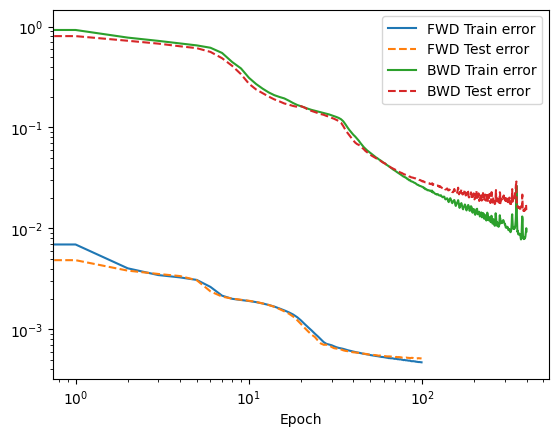

In [21]:
plt.plot(roundmodel_mlp.train_error_fwd,label='FWD Train error')
plt.plot(roundmodel_mlp.test_error_fwd,linestyle='--',label='FWD Test error')
plt.plot(roundmodel_mlp.train_error_bwd,label='BWD Train error')
plt.plot(roundmodel_mlp.test_error_bwd,linestyle='--',label='BWD Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### Random guess models (+RF FWD)

In [24]:
## Random guess 'model'
o2min=X_test['order2'].min()
o2max=X_test['order2'].max()
o3min=X_test['order3'].min()
o3max=X_test['order3'].max()
o4min=X_test['order4'].min()
o4max=X_test['order4'].max()

o2_list=[]
o3_list=[]
o4_list=[]
for i in range(len(X_test)):
    o2_list.append(random.uniform(o2min,o2max))
    o3_list.append(random.uniform(o3min,o3max))
    o4_list.append(random.uniform(o4min,o4max))

X_test_rand=pd.DataFrame({'order2':o2_list,'order3':o3_list,'order4':o4_list})#,o3_list,o4_list])#,columns=['order2','order3','order4'])

#Pass those predicted (but random) beta values to the forward model
y_pred_fwd_rand=forward_model_rf.predict(X_test_rand)
#calculate the error (Mean Absolute Error)
error_rand=abs(y_test-y_pred_fwd_rand)
error_rand=error_rand.sum(axis=1)/y_test.shape[1]

CVAE

In [27]:
#define the model
total_in=len(t_200)+len(X_train.columns) #number of input: pulse+Dazz
out_dim=len(X_train.columns)#dazz coefficients
cvae=models_vae.ConditionalVAE(
    in_pulse_features=len(t_200),
    num_param=out_dim,
    latent_dim=10,
    hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
    hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
)

batch_size = 10#just as an example
y_length=len(t_200)
x_length=len(X_train.columns)
summary(cvae,[(batch_size,x_length),(batch_size,y_length)])

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalVAE                           [10, 3]                   --
├─Sequential: 1-1                        [10, 51]                  --
│    └─Sequential: 2-1                   [10, 244]                 --
│    │    └─Linear: 3-1                  [10, 244]                 50,020
│    │    └─LeakyReLU: 3-2               [10, 244]                 --
│    └─Sequential: 2-2                   [10, 204]                 --
│    │    └─Linear: 3-3                  [10, 204]                 49,980
│    │    └─LeakyReLU: 3-4               [10, 204]                 --
│    └─Sequential: 2-3                   [10, 102]                 --
│    │    └─Linear: 3-5                  [10, 102]                 20,910
│    │    └─LeakyReLU: 3-6               [10, 102]                 --
│    └─Sequential: 2-4                   [10, 51]                  --
│    │    └─Linear: 3-7                  [10, 51]                  5,253


In [28]:
model_cvae,train_error,test_error=models_vae.train_vae(y_train,y_test,X_train,X_test,
			cvae,device,n_epochs=300,batch_size=32,print_freq=20,learning_rate=0.002)

Training on: cuda
Finished epoch 0,latest loss 0.5818955302238464
Finished epoch 20,latest loss 0.055378302931785583
Finished epoch 40,latest loss 0.04585372656583786
Finished epoch 60,latest loss 0.03364619240164757
Finished epoch 80,latest loss 0.02295556291937828
Finished epoch 100,latest loss 0.02047729305922985
Finished epoch 120,latest loss 0.016012609004974365
Finished epoch 140,latest loss 0.014958176761865616
Finished epoch 160,latest loss 0.014128781855106354
Finished epoch 180,latest loss 0.013546274043619633
Finished epoch 200,latest loss 0.01269055437296629
Finished epoch 220,latest loss 0.013649041764438152
Finished epoch 240,latest loss 0.01135589461773634
Finished epoch 260,latest loss 0.010752994567155838
Finished epoch 280,latest loss 0.01110159046947956
Finished epoch 299,latest loss 0.010747184976935387
Total time taken to train the model: 32.20s


Text(0.5, 0, 'Epoch')

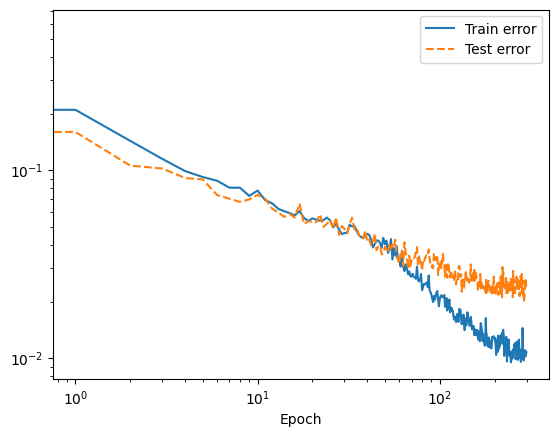

In [29]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')


## Predictions

In [31]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

In [34]:
#Take a pulse shpae (y_ex) and get the predicted Dazz from CVAE. Uses a FWD RF to predict the pulse shape
# X_train in the input is the dataset used to normalized the X
def pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodelNN,
                   df_input,t_200,X_train,y_test,device):
    #index_shot=150
    y_ex=y_test.iloc[index_shot]
    X_ex=X_test.iloc[index_shot]
    y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
    print(len(y_ex))
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,len(y_ex)))
    print('Known Dazzler values',X_ex)

    shot_numb=get_shot_num(index_shot,y_test,df_input)


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    
    y_order2=np.linspace(0,1,10)
    x_order2=np.full_like(y_order2,X_ex['order2'])

    y_order3=np.linspace(0,1,10)
    x_order3=np.full_like(y_order3,X_ex['order3'])

    y_order4=np.linspace(0,1,10)
    x_order4=np.full_like(y_order4,X_ex['order4'])


    num_bins=100

    weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
    weights_input2 = 10*np.ones_like(df_input['order2']) / len(df_input['order2'])

    weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
    weights_input3 = 14*np.ones_like(df_input['order3']) / len(df_input['order3'])

    weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
    weights_input4 = 5*np.ones_like(df_input['order4']) / len(df_input['order4'])

    #predictions from the RF roundtrip model
    y_predict_round_rf=roundmodel_rf.predict([y_ex])[0]
    X_predict_rf=roundmodel_rf.X_predict[0]
    
    y_o2_rf=np.linspace(0,1,10)
    x_o2_rf=np.full_like(y_o2_rf,X_predict_rf[0])

    y_o3_rf=np.linspace(0,1,10)
    x_o3_rf=np.full_like(y_o3_rf,X_predict_rf[1])

    y_o4_rf=np.linspace(0,1,10)
    x_o4_rf=np.full_like(y_o4_rf,X_predict_rf[2])

    #predictions from the NN roundtrip model
    y_predict_round_nn_cust=roundmodelNN.predict(pd.DataFrame([y_ex]))[0]
    X_predict_nn_cust=roundmodelNN.X_predict_nn[0]

    y_o2_nn=np.linspace(0,1,10)
    x_o2_nn=np.full_like(y_o2_nn,X_predict_nn_cust[0])

    y_o3_nn=np.linspace(0,1,10)
    x_o3_nn=np.full_like(y_o3_nn,X_predict_nn_cust[1])

    y_o4_nn=np.linspace(0,1,10)
    x_o4_nn=np.full_like(y_o4_nn,X_predict_nn_cust[2])

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    y_pred_fwd_cvae=forward_model_rf.predict(pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    mae_rf=abs(y_ex-y_predict_round_rf)
    mae_rf=mae_rf.sum()/len(y_ex)

    mae_mlp=abs(y_ex-y_predict_round_nn_cust)
    mae_mlp=mae_mlp.sum()/len(y_ex)

    mae_cvae=abs(y_ex-y_pred_fwd_cvae)
    mae_cvae=mae_cvae.sum()/len(y_ex)

    plt.subplot(1,5,(3,5))#one row, 4 columns, spanning from the first to the third
    plt.plot(t_200,y_ex,label='Real shot (#'+str(shot_numb)+')',linestyle='--',linewidth=3,color='tab:blue')
    plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef',linewidth=3,color='tab:orange')
    plt.plot(t_200,y_predict_round_rf,label='Prediction from RF',linewidth=3,color='tab:green')
    plt.plot(t_200,y_predict_round_nn_cust,label='Prediction from MLP',linewidth=3,color='tab:red')
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf),fontsize=16)
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp),fontsize=16)
    plt.text(-120,0.4,r'$MAE_{{CVAE}}={:.1f}$%'.format(100*mae_cvae),fontsize=16)
    plt.ylabel('Intensity',size=15)
    plt.xlabel('t(fs)',size=15)
    plt.legend(fontsize=14)

    plt.subplot(3,5,(1,2))#(3, 2, 1)
    plt.hist(df_input['order2'],bins=11,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'CVAE pred. $P(\beta_2|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order2,y_order2,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o2_rf,y_o2_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o2_nn,y_o2_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_2$',size=15)
    #plt.legend(fontsize=11)

    plt.subplot(3,5,(6,7))#(3, 2, 1)
    plt.hist(df_input['order3'],bins=17,weights=weights_input3,histtype="step",label=r'$P(\beta_x)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'CVAE pred. $P(\beta_x|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order3,y_order3,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o3_rf,y_o3_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o3_nn,y_o3_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_3$',size=15)
    plt.legend(fontsize=11)

    plt.subplot(3,5,(11,12))#(3, 2, 1)
    plt.hist(df_input['order4'],bins=6,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'CVAE pred $P(\beta_4|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order4,y_order4,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o4_rf,y_o4_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o4_nn,y_o4_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_4$',size=15)
    #plt.legend(fontsize=11)

    fig = plt.gcf()
    fig.set_size_inches(16, 7)
    fig.tight_layout()
    plt.show()

201
Known Dazzler values order2      35200.0
order3       7000.0
order4   -4900000.0
Name: 2137, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


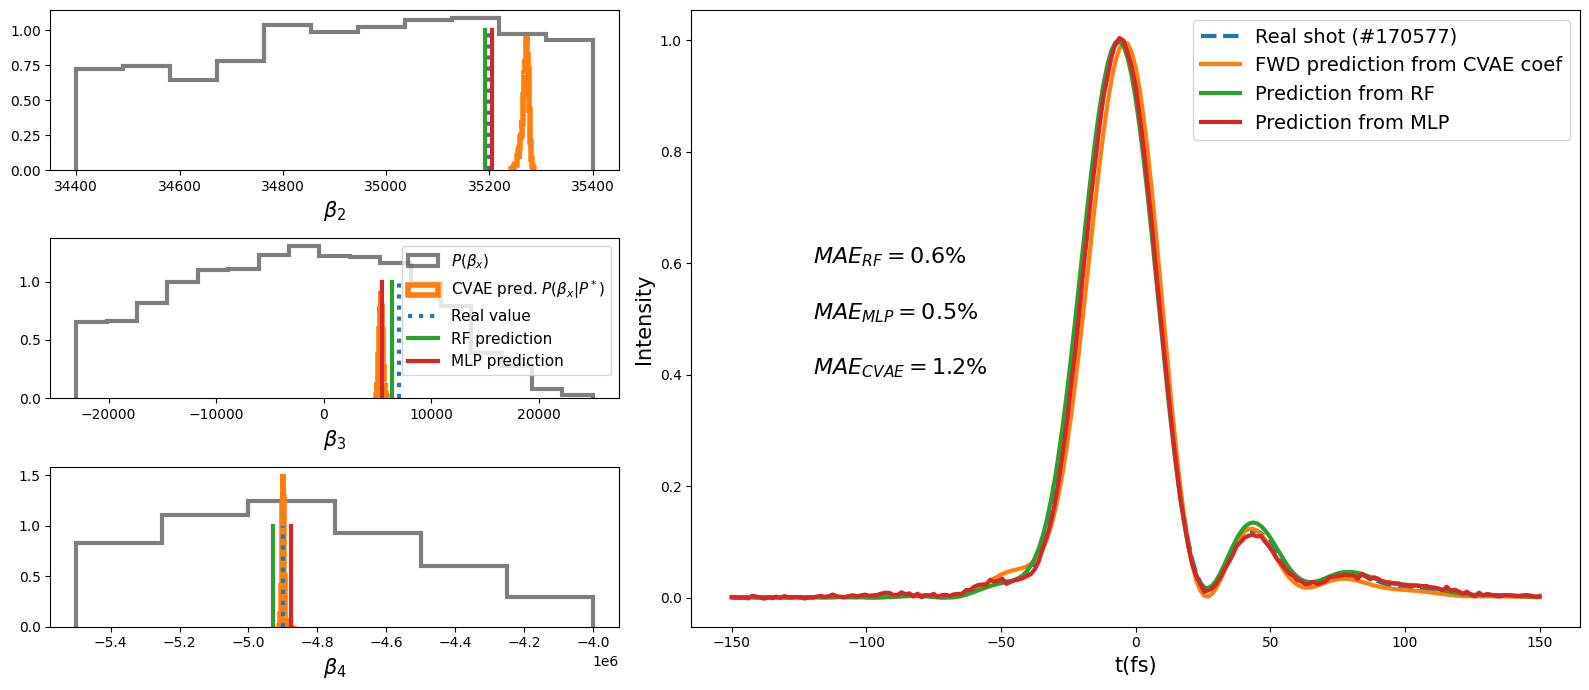

In [35]:
index_shot=106
pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,y_test,device)

201
Known Dazzler values order2      34600.0
order3     -17000.0
order4   -4600000.0
Name: 423, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


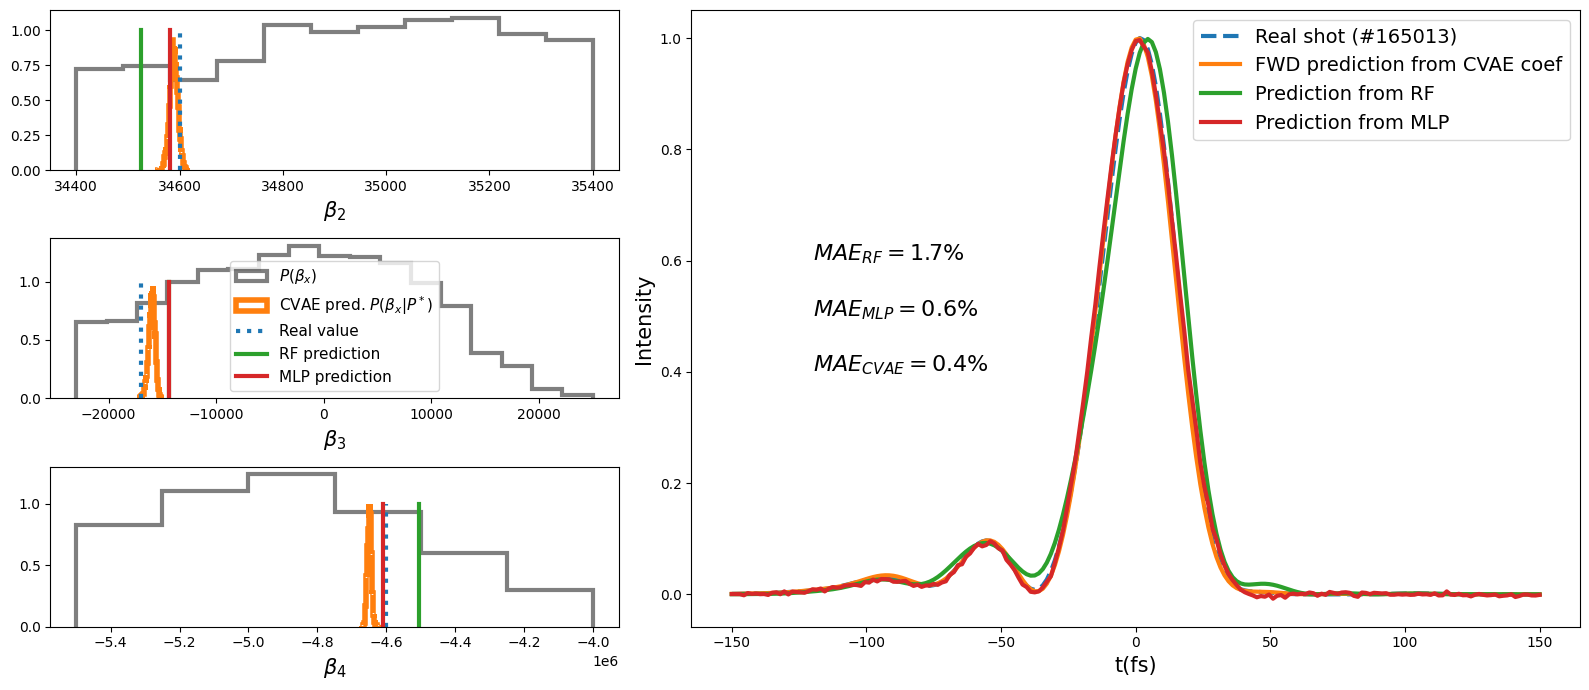

In [36]:
index_shot=125
pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,y_test,device)

### Calculate error from CVAE

In [37]:
# The function gets the Y from a given shot. Predicts its X values. Then uses those X to reconstruct a pulse Y
#        using the forward model. Finally calculates the error from the predictiona dn real Y
#NOTE: X_train is the data that was used to normalized the X values
def get_error_cvae(y_ex,model_cvae,forward_model_rf,X_train,device):
    y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,len(y_ex.values)))

    #Build the distributions functions P(D|p*)
    num_samples=10000
    #dazz_out_list=[]
    #for i in range(num_samples):
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)
        #dazz_out_list.append(dazz_out[0])
    #dazz_out_list=np.vstack(dazz_out_list)
    #P(D|p*) for each coefficient
    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    #get the highest prob value from those distr
    num_bins=100
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #Pass those predicted beta values to the forward model
    y_pred_fwd_cvae=forward_model_rf.predict(pd.DataFrame([(o2_pred,o3_pred,o4_pred)],columns=['order2', 'order3', 'order4']))[0]
    #calculate the error (Mean Absolute Error)
    error=abs(y_ex-y_pred_fwd_cvae)
    error=error.sum()/len(error)
    return error

In [38]:
cvae_error=[]
for i in range(len(y_test)):
    #index_shot=random.randint(0,len(y_test))
    y_ex=y_test.iloc[i]
    error_pred_cvae=get_error_cvae(y_ex,model_cvae,forward_model_rf,X_train,device)
    cvae_error.append(error_pred_cvae)
cvae_error=np.array(cvae_error)

### Comparison different models (include different dataset sizes)

### Genererate the small datasets

In [42]:
def drop_shots(drop_factor,df_input,df_time):
    remove_n = int(drop_factor*len(df_input)) #number of shots to be dropped
    drop_indices = np.random.choice(df_input.index, remove_n, replace=False)
    df_input_subset = df_input.drop(drop_indices)
    df_time_subset = df_time.drop(drop_indices)
    print('The datasize is no: '+str(len(df_time_subset)))
    return df_input_subset,df_time_subset#,df_freq_int_subset

In [43]:
drop_factor=0.45
df_input_subset_1500,df_time_subset_1500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.60
df_input_subset_1k,df_time_subset_1k=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.81
df_input_subset_500,df_time_subset_500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

The datasize is no: 1494
The datasize is no: 1087
The datasize is no: 517


In [44]:
#split the dataset (X:dazzler param, Y:wizzler) 
X_train_1500, X_test_1500, y_train_1500, y_test_1500=train_test_split(df_input_subset_1500[['order2', 'order3', 'order4']],df_time_subset_1500,test_size=0.3, random_state=101)
X_train_1k, X_test_1k, y_train_1k, y_test_1k=train_test_split(df_input_subset_1k[['order2', 'order3', 'order4']],df_time_subset_1k,test_size=0.3, random_state=101)
X_train_500, X_test_500, y_train_500, y_test_500=train_test_split(df_input_subset_500[['order2', 'order3', 'order4']],df_time_subset_500,test_size=0.3, random_state=101)


### Train the FWD models

In [46]:
#Training the Random Forest forward models
forward_model_rf_1500=train_rf_forward(X_train_1500, X_test_1500, y_train_1500, y_test_1500)
forward_model_rf_1k=train_rf_forward(X_train_1k, X_test_1k, y_train_1k, y_test_1k)
forward_model_rf_500=train_rf_forward(X_train_500, X_test_500, y_train_500, y_test_500)

### Train the ROUNDTRIP RF

In [47]:
roundmodel_rf_1500=models_rf.ROUNDmodelRF(X_train_1500,X_test_1500,y_train_1500,y_test_1500)
roundmodel_rf_1500.train()
y_predict_round_1500=roundmodel_rf_1500.predict(y_test_1500)
mae_error_round_rf_1500=roundmodel_rf_1500.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [48]:
roundmodel_rf_1k=models_rf.ROUNDmodelRF(X_train_1k,X_test_1k,y_train_1k,y_test_1k)
roundmodel_rf_1k.train()
y_predict_round_1k=roundmodel_rf_1k.predict(y_test_1k)
mae_error_round_rf_1k=roundmodel_rf_1k.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [49]:
roundmodel_rf_500=models_rf.ROUNDmodelRF(X_train_500,X_test_500,y_train_500,y_test_500)
roundmodel_rf_500.train()
y_predict_round_500=roundmodel_rf_500.predict(y_test_500)
mae_error_round_rf_500=roundmodel_rf_500.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### CVAE

In [52]:
#Create a CVAE model from a given dataset. Also train a FWD RF.
#Calculate the error in the predictions
def get_cvae_from_subset(t_200,df_input_subset,df_time_subset):
    X_train_subset, X_test_subset, y_train_subset, y_test_subset=train_test_split(df_input_subset[['order2', 'order3', 'order4']],df_time_subset, test_size=0.3, random_state=101)
    
    #norm the X (Dazz parameters)
    #X_train_norm_subset=models_fcnn.norm_data(X_train_subset,X_train_subset)
    #X_test_norm_subset=models_fcnn.norm_data(X_test_subset,X_train_subset)

    #convert data to tensors (no need to normalize values for Y)
    #y_train_tensor_subset=torch.tensor(y_train_subset.values,dtype=torch.float32)
    #y_test_tensor_subset=torch.tensor(y_test_subset.values,dtype=torch.float32)

    #X_train_tensor_subset=torch.tensor(X_train_norm_subset.values,dtype=torch.float32)
    #X_test_tensor_subset=torch.tensor(X_test_norm_subset.values,dtype=torch.float32)

    #define the model
    total_in=len(t_200)+len(X_train_subset.columns) #number of input: pulse+Dazz
    out_dim=len(X_train_subset.columns)#dazz coefficients
    model_subset=models_vae.ConditionalVAE(
        in_pulse_features=len(t_200),
        num_param=out_dim,
        latent_dim=10,
        hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
        hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
    )

    model_cvae_subset,train_error_subset,test_error_subset=models_vae.train_vae(y_train_subset,y_test_subset,X_train_subset,X_test_subset,
                model_subset,device,n_epochs=300,batch_size=32,print_freq=20,learning_rate=0.002)

    #train a RF forward model
    print('Training the RF FWD mode')
    forward_model_rf_subset=train_rf_forward(X_train_subset, X_test_subset, y_train_subset, y_test_subset)

    print('Calculating the error')
    cvae_error_subset=[]
    for i in range(len(y_test_subset)):
        #index_shot=random.randint(0,len(y_test))
        y_ex=y_test_subset.iloc[i]
        error_pred_cvae=get_error_cvae(y_ex,model_cvae_subset,forward_model_rf_subset,X_train_subset,device)
        cvae_error_subset.append(error_pred_cvae)
    cvae_error_subset=np.array(cvae_error_subset)
    return cvae_error_subset, model_cvae_subset

In [53]:
cvae_error_1500, model_cvae_1500=get_cvae_from_subset(t_200,df_input_subset_1500,df_time_subset_1500)

Training on: cuda
Finished epoch 0,latest loss 0.7758313417434692
Finished epoch 20,latest loss 0.08862520009279251
Finished epoch 40,latest loss 0.06277772784233093
Finished epoch 60,latest loss 0.042803484946489334
Finished epoch 80,latest loss 0.031821977347135544
Finished epoch 100,latest loss 0.028735680505633354
Finished epoch 120,latest loss 0.020692745223641396
Finished epoch 140,latest loss 0.01796838641166687
Finished epoch 160,latest loss 0.017056064680218697
Finished epoch 180,latest loss 0.016013693064451218
Finished epoch 200,latest loss 0.013281487859785557
Finished epoch 220,latest loss 0.014001434668898582
Finished epoch 240,latest loss 0.013843406923115253
Finished epoch 260,latest loss 0.011403415352106094
Finished epoch 280,latest loss 0.013609763234853745
Finished epoch 299,latest loss 0.014299953356385231
Total time taken to train the model: 17.98s
Training the RF FWD mode
Calculating the error


In [54]:
cvae_error_1k, model_cvae_1k=get_cvae_from_subset(t_200,df_input_subset_1k,df_time_subset_1k)

Training on: cuda
Finished epoch 0,latest loss 0.9417403936386108
Finished epoch 20,latest loss 0.10251522809267044
Finished epoch 40,latest loss 0.0797148197889328
Finished epoch 60,latest loss 0.029717324301600456
Finished epoch 80,latest loss 0.02366991713643074
Finished epoch 100,latest loss 0.023894792422652245
Finished epoch 120,latest loss 0.02174697071313858
Finished epoch 140,latest loss 0.01878485269844532
Finished epoch 160,latest loss 0.013109970837831497
Finished epoch 180,latest loss 0.017482707276940346
Finished epoch 200,latest loss 0.015764914453029633
Finished epoch 220,latest loss 0.012615296058356762
Finished epoch 240,latest loss 0.012573680840432644
Finished epoch 260,latest loss 0.010823220014572144
Finished epoch 280,latest loss 0.02068663015961647
Finished epoch 299,latest loss 0.01380116492509842
Total time taken to train the model: 13.38s
Training the RF FWD mode
Calculating the error


In [55]:
cvae_error_500, model_cvae_500=get_cvae_from_subset(t_200,df_input_subset_500,df_time_subset_500)

Training on: cuda
Finished epoch 0,latest loss 0.9996192455291748
Finished epoch 20,latest loss 0.1901349425315857
Finished epoch 40,latest loss 0.09869441390037537
Finished epoch 60,latest loss 0.06432132422924042
Finished epoch 80,latest loss 0.03713826835155487
Finished epoch 100,latest loss 0.029137171804904938
Finished epoch 120,latest loss 0.020202690735459328
Finished epoch 140,latest loss 0.024994738399982452
Finished epoch 160,latest loss 0.018057867884635925
Finished epoch 180,latest loss 0.037298690527677536
Finished epoch 200,latest loss 0.03274097666144371
Finished epoch 220,latest loss 0.014658919535577297
Finished epoch 240,latest loss 0.020536577329039574
Finished epoch 260,latest loss 0.02803441323339939
Finished epoch 280,latest loss 0.027330072596669197
Finished epoch 299,latest loss 0.044337183237075806
Total time taken to train the model: 6.87s
Training the RF FWD mode
Calculating the error


0      0.018145
1      0.037019
2      0.053949
3      0.090890
4      0.040770
         ...   
810    0.043057
811    0.027332
812    0.043868
813    0.055050
814    0.052478
Length: 815, dtype: float64
        Error Dataset Model
0    0.967241     500    RF
1    0.666918     500    RF
2    1.058362     500    RF
3    0.470056     500    RF
4    1.960825     500    RF
..        ...     ...   ...
810  0.346261    3000  CVAE
811  0.648639    3000  CVAE
812  0.877197    3000  CVAE
813  0.728918    3000  CVAE
814  0.545529    3000  CVAE

[3494 rows x 3 columns]


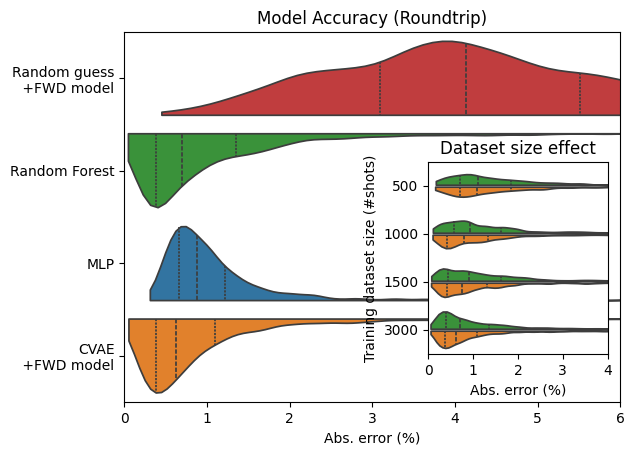

In [56]:
fig = plt.figure() #fig needed to add_axes later
error_rand_reset=error_rand.reset_index(drop=True)
print(error_rand_reset)
df_plot=pd.DataFrame({'Random guess\n +FWD model':100*error_rand_reset,
                      'Random Forest':100*mae_error_round,
                      'MLP':100*error_round_model_mlp, 'CVAE\n +FWD model':100*cvae_error})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
#print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.6,split=True,orient='h',
               palette=['tab:red','tab:green','tab:blue','tab:orange'])
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (Roundtrip)')
plt.xlim(0,6)

#inset plot (the datasize effect)
df_plot=pd.DataFrame({'Error':100*mae_error_round_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_500,'Dataset':'500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1k,'Dataset':'1000','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1500,'Dataset':'1500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error,'Dataset':'3000','Model':'CVAE'})))

print(df_plot)
ax = fig.add_axes([0.60, 0.21, 0.28, 0.40], facecolor='white') #[left, bottom, width, height]

sns.violinplot(data=df_plot,y='Dataset',x='Error',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.4,split=True,orient='h',
               palette=['tab:green','tab:orange'])
plt.xlabel('Abs. error (%)')
plt.ylabel('Training dataset size (#shots)')
plt.title('Dataset size effect')
plt.xlim(0,4)
ax.get_legend().remove()